# Open and Globular Cluster Benchmark

To see the scattering of neural network and compared to ASPCAP

E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!
Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
M67  and number of stars:  38
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 0.35s in total
Neural Network star cluster median abundances and uncertainty in median (ASPCAP)
C : -0.0373+/-0.0061  (-0.0571+/-0.0089)
C1 : -0.1157+/-0.0052  (-0.1231+/-0.0075)
N : 0.4369+/-0.0120  (0.4744+/-0.0148)
O : 0.0416+/-0.0043  (0.0433+/-0.0045)
Na : 0.1582+/-0.0082  (0.1994+/-0.0126)
Mg : 0.0909+/-0.0055  (0.0869+/-0.0048)
Al : 0.0931+/-0.0075  (0.0611+/-0.0111)
Si : 0.0699+/-0.0067  (0.0598+/-0.0076)
P : 0.0228+/-0.0063  (0.0347+/-0.0136)
S : 0.0350+/-0.0043  (0.0434+/-0.0058)
K : 0.0716+/-0.0035  (0.0663+/-0.0060)
Ca : 0.0680+/-0.0041  (0.0656+/-0.0054)
Ti : 0.0722+/-0.0053  (0.0538+/-0.0055)
Ti2 : 0.0195+/-0.0148  (0.0419+/-0.0188)
V : 0.0612+/-0.0072  (0.0172+/-0

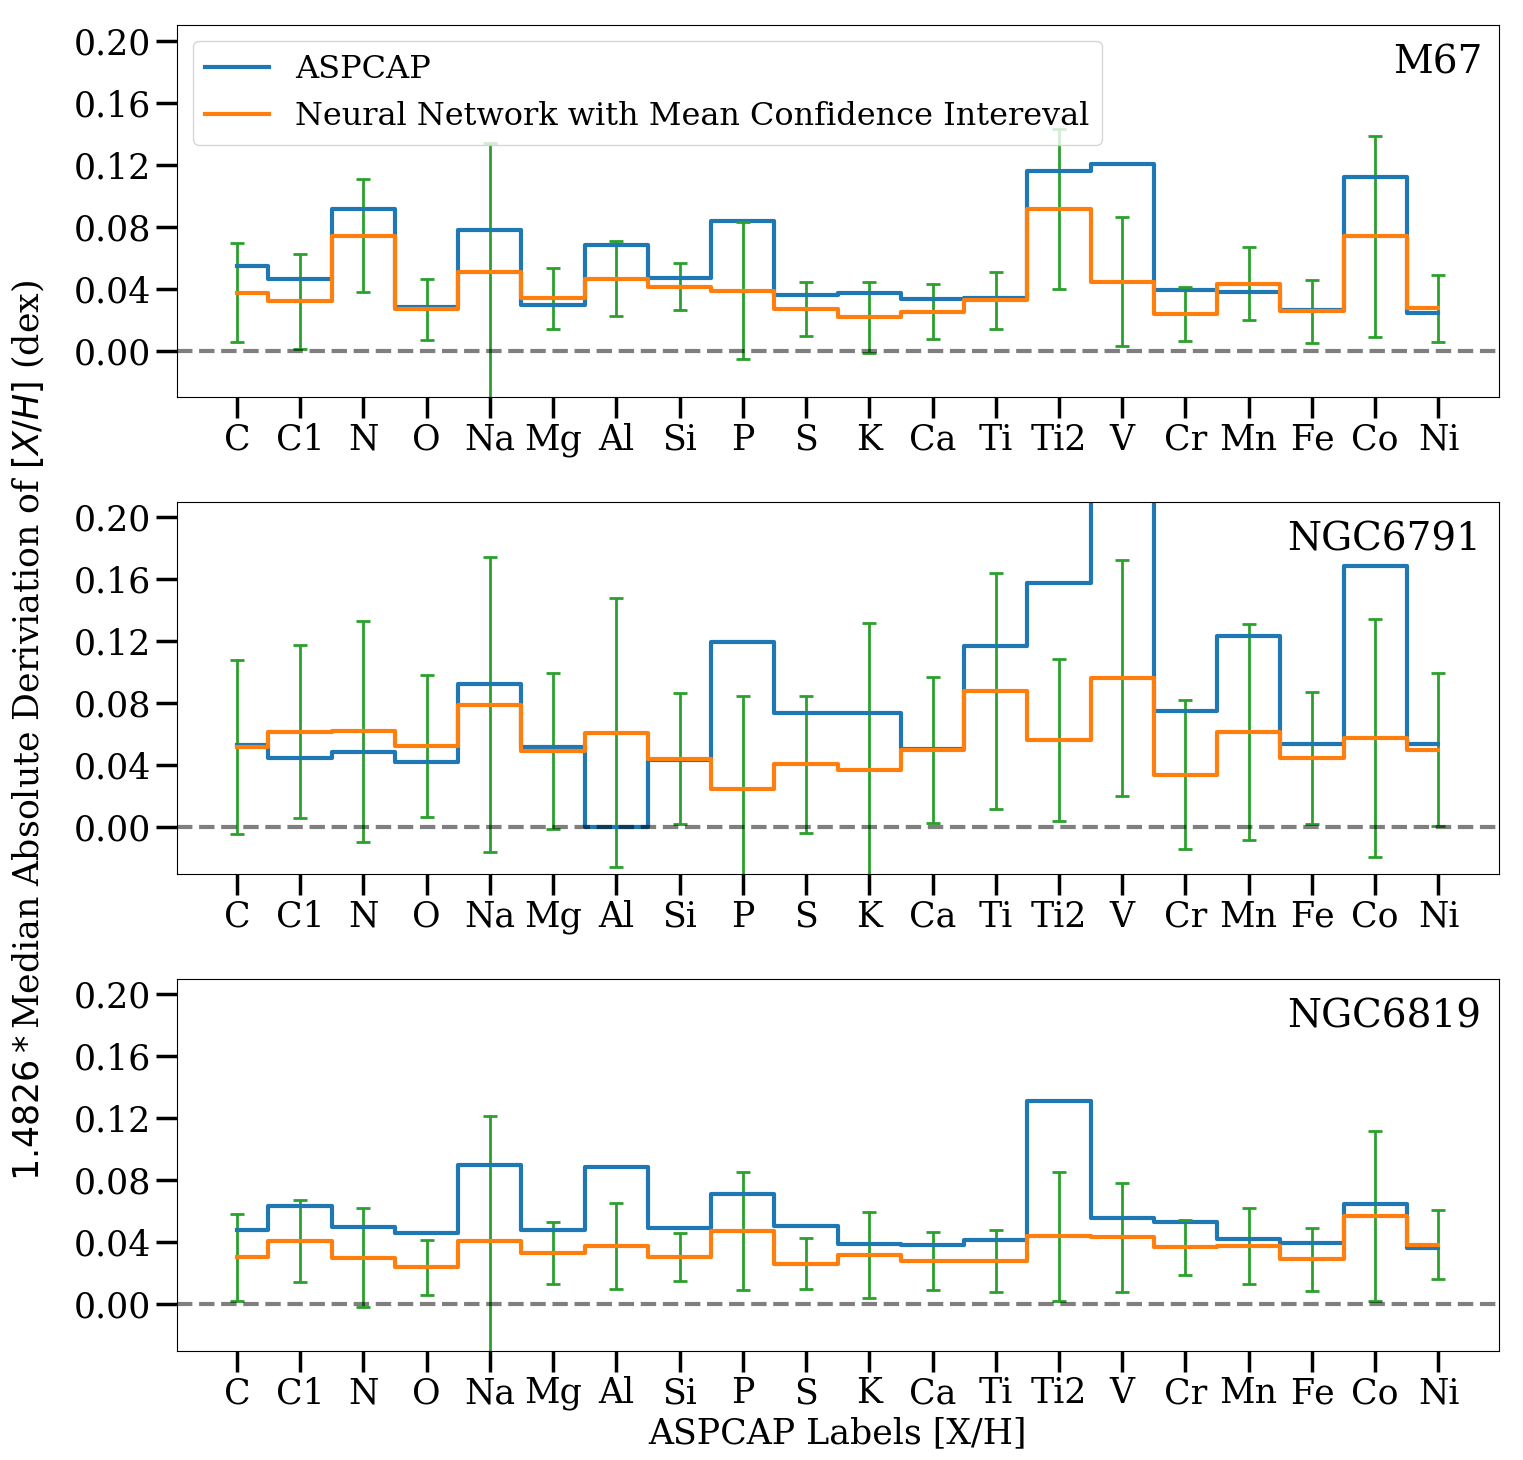

In [3]:
import numpy as np
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter
import astropy.io.ascii
from astropy.stats import mad_std
from astropy.io import fits

from astroNN.apogee import allstar
from astroNN.apogee import visit_spectra
from astroNN.apogee.chips import apogee_continuum
from astroNN.models import load_folder

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# load APOGEE allstar file
all_star = fits.getdata(allstar(dr=14))

# Same target bit used in the paper
target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]

# setup the continuum normalization function such that did the same thing as the standard procedure used in the paper
def apstar_normalization(spectra, spectra_err, _spec_mask):
    return apogee_continuum(spectra=spectra, spectra_err=spectra_err, cont_mask=None, deg=2, dr=14, bitmask=_spec_mask)

# load the trained neural network model described in the paper
bcnn = load_folder('astroNN_0520_run001')
targetname = bcnn.targetname  # find out which neural repsondable to what

# load open cluster data
data = astropy.io.ascii.read('aj485195t4_mrt.txt')
uni_names = np.unique(np.array(data['col2']))  # find unique cluster name

# loop throught the clusters
for name in uni_names:
    # In the paper, we only plot these 3 clusters, M67, NGC6791 and NGC6819 in open cluster category
    if name not in ['M67', 'N6791', 'N6819']:
        continue
                
    # find all the APOGEE ID associated with that cluster
    apogeeid_name_idx = np.where(data['col2']==name)
     # find indices for those APOGEE ID in allstar
    indices = np.where(np.in1d(all_star['APOGEE_ID'], data['col1'][apogeeid_name_idx]))[0]
    # retrieve info on those APOGEE spectra
    aid = all_star['APOGEE_ID'][indices]
    loc_id = all_star['LOCATION_ID'][indices]
    # 0-20 are indices representing output neurones from ASPCAP chemical abundances (C/H to Ni/H)
    aspcap_result = all_star['X_H'][indices, 0:20]
     
    # pre-allocation of spectra array
    spec = np.zeros((indices.shape[0], 7514))

    for counter, idx in enumerate(aid):
        apstar_file = fits.open(visit_spectra(dr=14, location=loc_id[counter], apogee=aid[counter], verbose=0))
        nvisits = apstar_file[0].header['NVISITS']
        # we want combined spectra
        if nvisits == 1:
            _spec = apstar_file[1].data
            _spec_err = apstar_file[2].data
            _spec_mask = apstar_file[3].data
        else:
            _spec = apstar_file[1].data[1]
            _spec_err = apstar_file[2].data[1]
            _spec_mask = apstar_file[3].data[1]
        # continuum normalization of spectra
        _spec, _spec_err = apstar_normalization(_spec, _spec_err, _spec_mask)
        spec[counter] = _spec

    print(name, ' and number of stars: ', indices.shape[0])
    
    # Bayesian Neural Network Inference
    pred, pred_err = bcnn.test(spec[1:])
    # 4-24 are indices representing ASPCAP chemical abundances from output neurones (C/H to Ni/H)
    pred_scatter = mad_std(pred[:,4:24], axis=0)
    mean_uncertainty = np.mean(pred_err['total'][:, 4:24], axis=0)
    aspcap_scatter = mad_std(aspcap_result, axis=0)
    
    if name=='M67':
        m67_nn_scatter = np.array(pred_scatter)
        m67_nn_m_uncer = np.array(mean_uncertainty)
        m67_aspcap = np.array(aspcap_scatter)
        
        m67_aspcap_mean = np.median(aspcap_result, axis=0)
        m67_aspcap_uncer = mad_std(aspcap_result, axis=0) / np.sqrt(indices.shape[0])

        m67_nn_mean = np.median(pred[:,4:24], axis=0)
        m67_nn_uncer_in_mean = mad_std(pred[:,4:24], axis=0) / np.sqrt(indices.shape[0])
            
        print('Neural Network star cluster median abundances and uncertainty in median (ASPCAP)')
        for i in range(20):
            print(bcnn.targetname[4:24][i], f': {m67_nn_mean[i]:.{4}f}+/-{m67_nn_uncer_in_mean[i]:.{4}f}', 
                  f' ({m67_aspcap_mean[i]:.{4}f}+/-{m67_aspcap_uncer[i]:.{4}f})')
        print('=====================================\n')

    elif name=='N6791':
        n6791_nn_scatter = np.array(pred_scatter)
        n6791_nn_m_uncer = np.array(mean_uncertainty)
        n6791_aspcap = np.array(aspcap_scatter)
        
        n6791_aspcap_mean = np.median(aspcap_result, axis=0)
        n6791_aspcap_uncer = mad_std(aspcap_result, axis=0) / np.sqrt(indices.shape[0])

        n6791_nn_mean = np.median(pred[:,4:24], axis=0)
        n6791_nn_uncer_in_mean = mad_std(pred[:,4:24], axis=0) / np.sqrt(indices.shape[0])
            
        print('Neural Network star cluster median abundances and uncertainty in median (ASPCAP)')
        for i in range(20):
            print(bcnn.targetname[4:24][i], f': {n6791_nn_mean[i]:.{4}f}+/-{n6791_nn_uncer_in_mean[i]:.{4}f}', 
                  f' ({n6791_aspcap_mean[i]:.{4}f}+/-{n6791_aspcap_uncer[i]:.{4}f})')
        print('=====================================\n')
        
    elif name=='N6819':
        n6819_nn_scatter = np.array(pred_scatter)
        n6819_nn_m_uncer = np.array(mean_uncertainty)
        n6819_aspcap = np.array(aspcap_scatter)
        
        n6819_aspcap_mean = np.median(aspcap_result, axis=0)
        n6819_aspcap_uncer = mad_std(aspcap_result, axis=0) / np.sqrt(indices.shape[0])

        n6819_nn_mean = np.median(pred[:,4:24], axis=0)
        n6819_nn_uncer_in_mean = mad_std(pred[:,4:24], axis=0) / np.sqrt(indices.shape[0])
            
        print('Neural Network star cluster median abundances and uncertainty in median (ASPCAP)')
        for i in range(20):
            print(bcnn.targetname[4:24][i], f': {n6819_nn_mean[i]:.{4}f}+/-{n6819_nn_uncer_in_mean[i]:.{4}f}', 
                  f' ({n6819_aspcap_mean[i]:.{4}f}+/-{n6819_aspcap_uncer[i]:.{4}f})')
        print('======================================\n')
            
ml = MultipleLocator(0.04)        

# setup plots
f, ax = plt.subplots(3, figsize=(15,15), dpi=100)

ax[0].plot(m67_aspcap, ls='steps-mid', linewidth=3., 
           label='ASPCAP')
ax[0].plot(m67_nn_scatter, ls='steps-mid', linewidth=3., 
           label='Neural Network with Mean Confidence Intereval')
ax[0].errorbar(np.arange(20), m67_nn_scatter, yerr=m67_nn_m_uncer, 
               linestyle='None', capsize=5, elinewidth=2., capthick=2.)
ax[0].set_ylim((-0.03, 0.21))
ax[0].annotate("M67", xy=(0.92,0.87),xycoords='axes fraction', fontsize=28)
ax[0].legend(loc='upper left', fontsize=23)
ax[0].set_xticks(np.arange(len([xn for xn in bcnn.targetname[4:24]])))
ax[0].set_xticklabels([f"{xn}" for xn in bcnn.targetname[4:24]])
ax[0].yaxis.set_major_locator(ml)
ax[0].tick_params(labelsize=25, width=2.5, length=15, which='major')
ax[0].tick_params(axis='y',labelsize=25, width=2, length=7, which='minor')
ax[0].axhline(0.00, ls='--', c='k', lw=3., alpha=0.5)
# ax[0].yaxis.set_minor_locator(ml)

ax[1].plot(n6791_aspcap, ls='steps-mid', linewidth=3.)
ax[1].plot(n6791_nn_scatter, ls='steps-mid', linewidth=3.)
ax[1].errorbar(np.arange(20), n6791_nn_scatter, yerr=n6791_nn_m_uncer, 
               linestyle='None', capsize=5, elinewidth=2., capthick=2)
ax[1].annotate("NGC6791", xy=(0.84,0.87),xycoords='axes fraction', fontsize=28)
ax[1].set_ylim((-0.03, 0.21))
ax[1].set_xticks(np.arange(len([xn for xn in bcnn.targetname[4:24]])))
ax[1].tick_params(labelsize=25, width=2.5, length=15, which='major')
ax[1].set_xticklabels([f"{xn}" for xn in bcnn.targetname[4:24]])
ax[1].yaxis.set_major_locator(ml)
ax[1].axhline(0.00, ls='--', c='k', lw=3., alpha=0.5)

ax[2].plot(n6819_aspcap, ls='steps-mid', linewidth=3.)
ax[2].plot(n6819_nn_scatter, ls='steps-mid', linewidth=3.)
ax[2].errorbar(np.arange(20), n6819_nn_scatter, yerr=n6819_nn_m_uncer, 
               linestyle='None', capsize=5, elinewidth=2., capthick=2.)
ax[2].annotate("NGC6819", xy=(0.84,0.87),xycoords='axes fraction', fontsize=28)
ax[2].set_ylim((-0.03, 0.21))
ax[2].set_xticks(np.arange(len([xn for xn in bcnn.targetname[4:24]])))
ax[2].set_xticklabels([f"{xn}" for xn in bcnn.targetname[4:24]])
ax[2].tick_params(labelsize=25, width=2.5, length=15, which='major')
ax[2].yaxis.set_major_locator(ml)
ax[2].axhline(0.00, ls='--', c='k', lw=3., alpha=0.5)
ax[2].set_xlabel('ASPCAP Labels [X/H]', fontsize=25)

f.text(-0.01, 0.5, '$1.4826*$'+'Median Absolute Deriviation of '+'$[X/H]$'+' (dex)', ha='center', 
       va='center', fontdict={'fontsize':25}, rotation='vertical')
f.tight_layout()

f.savefig('open_clusters.png')

E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!
Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
M13  and number of stars:  87
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 0.72s in total
Neural Network star cluster median abundances and uncertainty in median (ASPCAP)
C : -1.8017+/-0.0153  (-1.9475+/-0.0342)
C1 : -1.5545+/-0.0138  (-1.9183+/-0.0491)
N : -1.4741+/-0.0170  (-1.2438+/-0.0986)
O : -1.3193+/-0.0093  (-1.6356+/-0.0457)
Na : -0.8353+/-0.0079  (-9999.0000+/-0.0000)
Mg : -1.3447+/-0.0123  (-1.5043+/-0.0198)
Al : -1.8244+/-0.0170  (-1.6612+/-0.1179)
Si : -1.2856+/-0.0106  (-1.3266+/-0.0120)
P : -1.6333+/-0.0122  (-1.7280+/-0.1403)
S : -1.1654+/-0.0080  (-1.2911+/-0.0458)
K : -1.3816+/-0.0116  (-1.6148+/-0.0312)
Ca : -1.4018+/-0.0120  (-1.4719+/-0.0319)
Ti : -1.5154+/-0.0108  (-1.5072+/-0.0253)
Ti2 : -1.3568+/-0.0123  (-1.6521+/-0.1204)
V : -

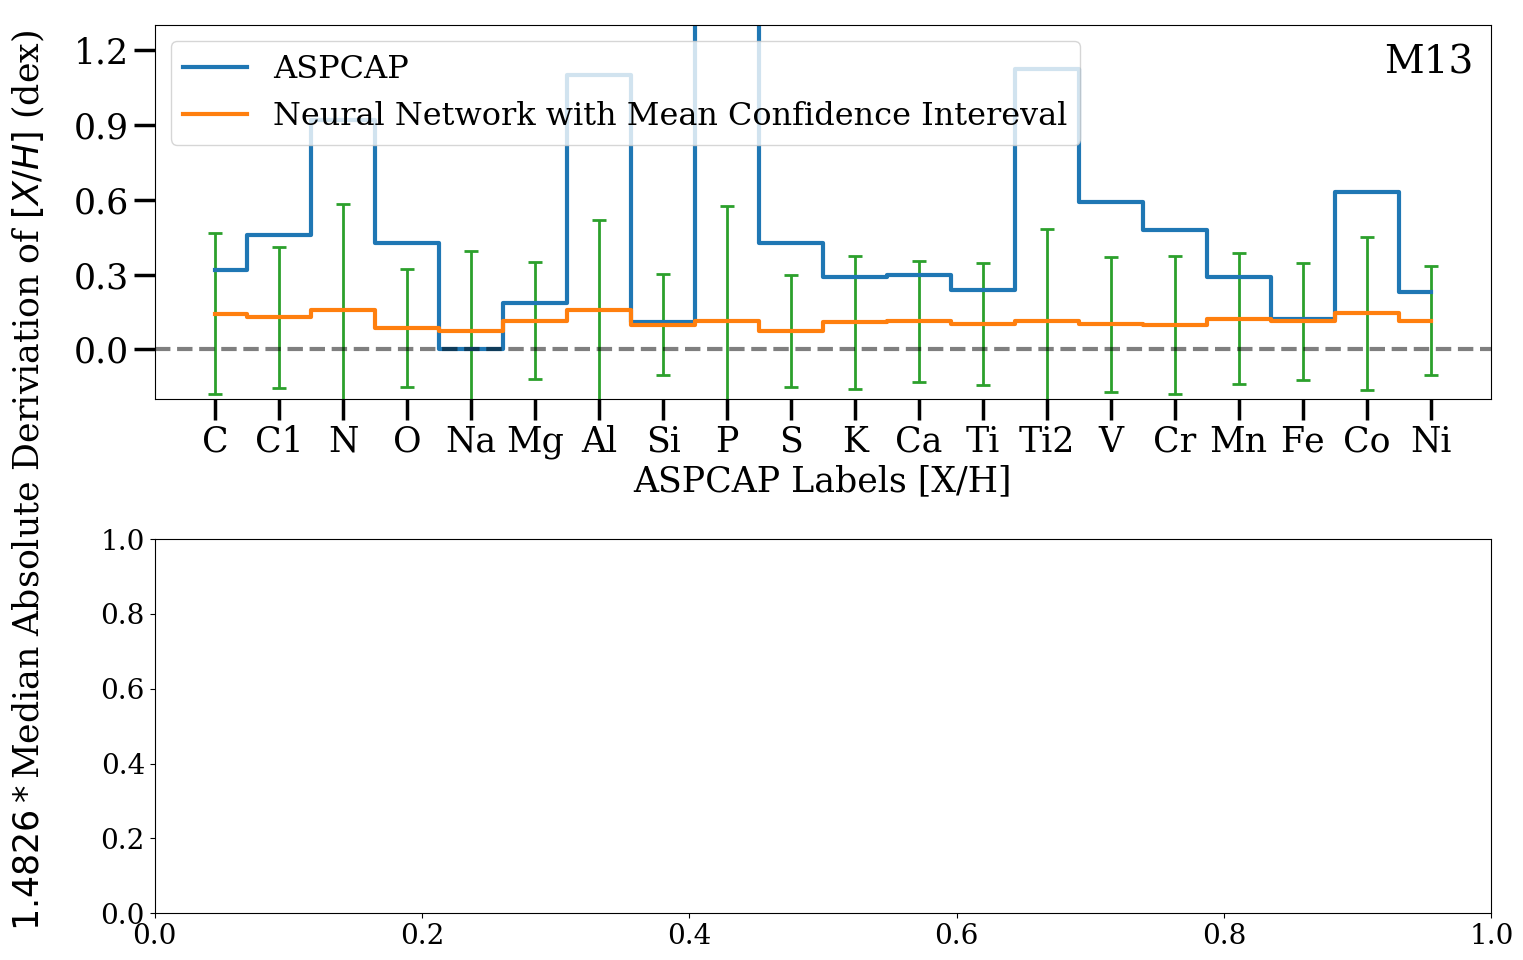

In [2]:
import numpy as np
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter
import astropy.io.ascii
from astropy.stats import mad_std
from astropy.io import fits

from astroNN.apogee import allstar
from astroNN.apogee import visit_spectra
from astroNN.apogee.chips import apogee_continuum
from astroNN.models import load_folder

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# load APOGEE allstar file
all_star = fits.getdata(allstar(dr=14))

# Same target bit used in the paper
target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]

# setup the continuum normalization function such that did the same thing as the standard procedure used in the paper
def apstar_normalization(spectra, spectra_err, _spec_mask):
    return apogee_continuum(spectra=spectra, spectra_err=spectra_err, cont_mask=None, deg=2, dr=14, bitmask=_spec_mask)

# load the trained neural network model described in the paper
bcnn = load_folder('astroNN_0520_run001')
targetname = bcnn.targetname  # find out which neural repsondable to what

# load open cluster data
data = astropy.io.ascii.read('aj485195t4_mrt.txt')
uni_names = np.unique(np.array(data['col2']))  # find unique cluster name

# loop throught the clusters
for name in uni_names:
    # In the paper, we only plot these M13 in globular cluster category
    if name not in ['M13']:
        continue
                
    # find all the APOGEE ID associated with that cluster
    apogeeid_name_idx = np.where(data['col2']==name)
     # find indices for those APOGEE ID in allstar
    indices = np.where(np.in1d(all_star['APOGEE_ID'], data['col1'][apogeeid_name_idx]))[0]
    # retrieve info on those APOGEE spectra
    aid = all_star['APOGEE_ID'][indices]
    loc_id = all_star['LOCATION_ID'][indices]
    # 0-20 are indices representing output neurones from ASPCAP chemical abundances (C/H to Ni/H)
    aspcap_result = all_star['X_H'][indices, 0:20]
     
    # pre-allocation of spectra array
    spec = np.zeros((indices.shape[0], 7514))

    for counter, idx in enumerate(aid):
        apstar_file = fits.open(visit_spectra(dr=14, location=loc_id[counter], apogee=aid[counter], verbose=0))
        nvisits = apstar_file[0].header['NVISITS']
        # we want combined spectra
        if nvisits == 1:
            _spec = apstar_file[1].data
            _spec_err = apstar_file[2].data
            _spec_mask = apstar_file[3].data
        else:
            _spec = apstar_file[1].data[1]
            _spec_err = apstar_file[2].data[1]
            _spec_mask = apstar_file[3].data[1]
        # continuum normalization of spectra
        _spec, _spec_err = apstar_normalization(_spec, _spec_err, _spec_mask)
        spec[counter] = _spec

    print(name, ' and number of stars: ', indices.shape[0])
    
    # Bayesian Neural Network Inference
    pred, pred_err = bcnn.test(spec[1:])
    # 4-24 are indices representing ASPCAP chemical abundances from output neurones (C/H to Ni/H)
    m13_nn_scatter = mad_std(pred[:,4:24], axis=0)
    m13_nn_m_uncer = np.mean(pred_err['total'][:, 4:24], axis=0)
    m13_aspcap = mad_std(aspcap_result, axis=0)

    m13_aspcap_mean = np.median(aspcap_result, axis=0)
    m13_aspcap_uncer = mad_std(aspcap_result, axis=0) / np.sqrt(indices.shape[0])
    
    m13_nn_mean = np.median(pred[:,4:24], axis=0)
    m13_nn_uncer_in_mean = mad_std(pred[:,4:24], axis=0) / np.sqrt(indices.shape[0])
    
    print('Neural Network star cluster median abundances and uncertainty in median (ASPCAP)')
    for i in range(20):
        print(bcnn.targetname[4:24][i], f': {m13_nn_mean[i]:.{4}f}+/-{m13_nn_uncer_in_mean[i]:.{4}f}', 
              f' ({m13_aspcap_mean[i]:.{4}f}+/-{m13_aspcap_uncer[i]:.{4}f})')

ml = MultipleLocator(0.04)        

# setup plots
f, ax = plt.subplots(2, figsize=(15,10), dpi=100)

ax[0].plot(m13_aspcap, ls='steps-mid', linewidth=3., 
           label='ASPCAP')
ax[0].plot(m13_nn_scatter, ls='steps-mid', linewidth=3., 
           label='Neural Network with Mean Confidence Intereval')
ax[0].errorbar(np.arange(20), m13_nn_scatter, yerr=m13_nn_m_uncer, 
               linestyle='None', capsize=5, elinewidth=2., capthick=2.)
ax[0].legend(loc='upper left', fontsize=23)

ax[0].annotate("M13", xy=(0.92,0.87),xycoords='axes fraction', fontsize=28)
ax[0].set_xlabel('ASPCAP Labels [X/H]', fontsize=25)
ax[0].set_ylim((-0.20, 1.3))
ax[0].set_xticks(np.arange(len([xn for xn in bcnn.targetname[4:24]])))
ax[0].set_xticklabels([f"{xn}" for xn in bcnn.targetname[4:24]])
ax[0].tick_params(labelsize=25, width=2.5, length=15, which='major')
ax[0].yaxis.set_major_locator(MultipleLocator(0.3))
ax[0].axhline(0.00, ls='--', c='k', lw=3., alpha=0.5)

f.text(-0.01, 0.5, '$1.4826*$'+'Median Absolute Deriviation of '+'$[X/H]$'+' (dex)', ha='center', 
       va='center', fontdict={'fontsize':25}, rotation='vertical')
f.tight_layout()

f.savefig('m13.png')